In [86]:
import deepinv as dinv
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from deepinv.models import DRUNet
from deepinv.optim.data_fidelity import L2
from deepinv.optim.prior import PnP
from deepinv.optim.optimizers import optim_builder
from deepinv.utils.demo import load_url_image, get_image_url
from deepinv.utils.plotting import plot
from deepinv.optim.phase_retrieval import correct_global_phase, cosine_similarity
from deepinv.models.complex import to_complex_denoiser

In [87]:
BASE_DIR = Path(".")
RESULTS_DIR = BASE_DIR / "results"
# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

In [90]:
# Set up the variable to fetch dataset and operators.
img_size = 32
url = get_image_url("SheppLogan.png")
x = load_url_image(
    url=url, img_size=img_size, grayscale=True, resize_mode="resize", device=device
)
x.shape

torch.Size([1, 1, 32, 32])

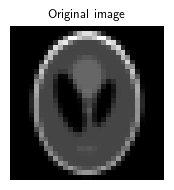

In [91]:
plot(x, titles="Original image")

In [92]:
# We use the original image as the phase information for the complex signal.
# The phase is computed as 2*pi*x - pi, where x is the original image.
x_phase = torch.exp(1j*x*torch.pi - 0.5j*torch.pi)

# Every element of the signal should have unit norm.
assert torch.allclose(x_phase.real**2 + x_phase.imag**2, torch.tensor(1.0))

In [94]:
oversampling_ratio = 2.0
img_shape = x.shape[1:]
m = int(oversampling_ratio * torch.prod(torch.tensor(img_shape)))

noise_level_img = 0.05  # Gaussian Noise standard deviation for the degradation
n_channels = 1  # 3 for color images, 1 for gray-scale images
physics = dinv.physics.RandomPhaseRetrieval(
    m=m,
    img_shape=img_shape,
    noise_model=dinv.physics.GaussianNoise(sigma=noise_level_img),
)
y = physics(x_phase)

In [101]:
data_fidelity = L2()
# Step size for the gradient descent
stepsize = 0.20 * oversampling_ratio / 5.0
num_iter = 3000

loss_init: tensor([245.7525])
loss_final: tensor([0.4771])


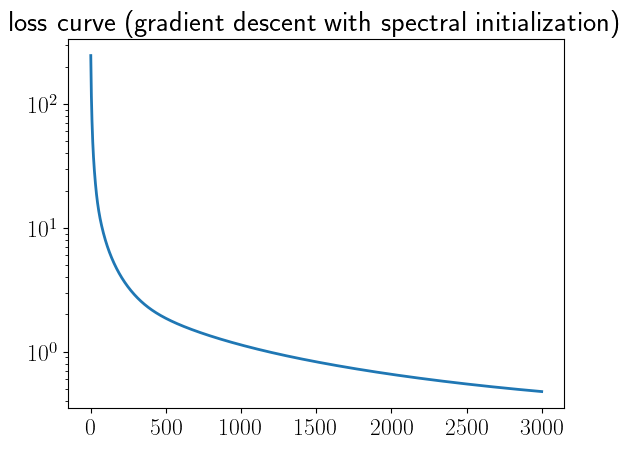

In [102]:
# spectral methods
x_phase_gd_spec = physics.A_dagger(y,n_iter=300)
x_phase_gd_spec = x_phase_gd_spec * torch.sqrt(y.sum())
loss_hist = []
for _ in range(num_iter):
    x_phase_gd_spec = x_phase_gd_spec - stepsize * data_fidelity.grad(x_phase_gd_spec, y, physics)
    loss_hist.append(data_fidelity(x_phase_gd_spec, y, physics))

print("loss_init:",loss_hist[0])
print("loss_final:",loss_hist[-1])
plt.plot(loss_hist)
plt.yscale('log')
plt.title('loss curve (gradient descent with spectral initialization)')
plt.show()

Image 0, channel 0 does not have a global phase shift.


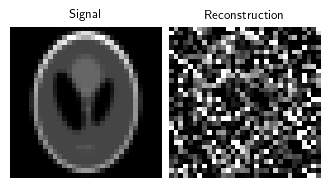

In [104]:
# correct possible global phase shifts
x_gd_spec = correct_global_phase(x_phase_gd_spec, x_phase)
# extract phase information and normalize to the range [0, 1]
x_gd_spec = torch.angle(x_gd_spec) / torch.pi + 0.5
plot([x, x_gd_spec],titles=["Signal","Reconstruction"],rescale_mode='clip')

# Pseudorandom Case

In [106]:
x = torch.rand((1,3,3))
y = torch.nn.ZeroPad2d(0)(x)
print(x)
print(y)

tensor([[[0.4002, 0.8554, 0.6920],
         [0.1113, 0.6053, 0.8484],
         [0.1746, 0.2610, 0.7693]]])
tensor([[[0.4002, 0.8554, 0.6920],
         [0.1113, 0.6053, 0.8484],
         [0.1746, 0.2610, 0.7693]]])
